<a href="https://colab.research.google.com/github/godlejr/PytorchSkeleton/blob/main/pytoch_GPU_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Pytorch 1.0 (For Google Colab)

In [ ]:
#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)


     |████████████████████████████████| 591.8 MB 638 bytes/s 
     |████████████████████████████████| 23.3 MB 72.8 MB/s 
     |████████████████████████████████| 22.1 MB 57.9 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 17.4 MB 127 kB/s 
     |████████████████████████████████| 17.3 MB 15 kB/s 
     |████████████████████████████████| 12.8 MB 20 kB/s 
     |████████████████████████████████| 12.7 MB 88 kB/s 
     |████████████████████████████████| 11.8 MB 9.2 MB/s 
     |████████████████████████████████| 5.9 MB 16.7 MB/s 
     |████████████████████████████████| 6.6 MB 11.9 MB/s 
     |████████████████████████████████| 6.6 MB 28.3 MB/s 
     |████████████████████████████████| 4.0 MB 42.0 MB/s 
     |████████████████████████████████| 10.2 MB 12.3 MB/s 
     |████████████████████████████████| 10.1 MB 15.1 MB/s 
     |████████████████████████████████| 8.8 MB 6.6 MB/s 
     |████████████████████████████████| 2.6 MB 60.3 MB/s 
     |████

### 1. Data Preparation

**Data Set**  
$$X_{train} \in \mathcal{R}^{50000 \times 784}, Y_{train} \in \mathcal{Z}^{50000}$$  
$$X_{val} \in \mathcal{R}^{10000 \times 784}, Y_{val} \in \mathcal{Z}^{10000}$$  
$$X_{test} \in \mathcal{R}^{10000 \times 784}, Y_{test} \in \mathcal{Z}^{10000}$$

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

9920512it [00:02, 3560329.59it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 554392.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 3191585.30it/s]                             


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 158358.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
50000 10000 10000


### Inspecting Dataset

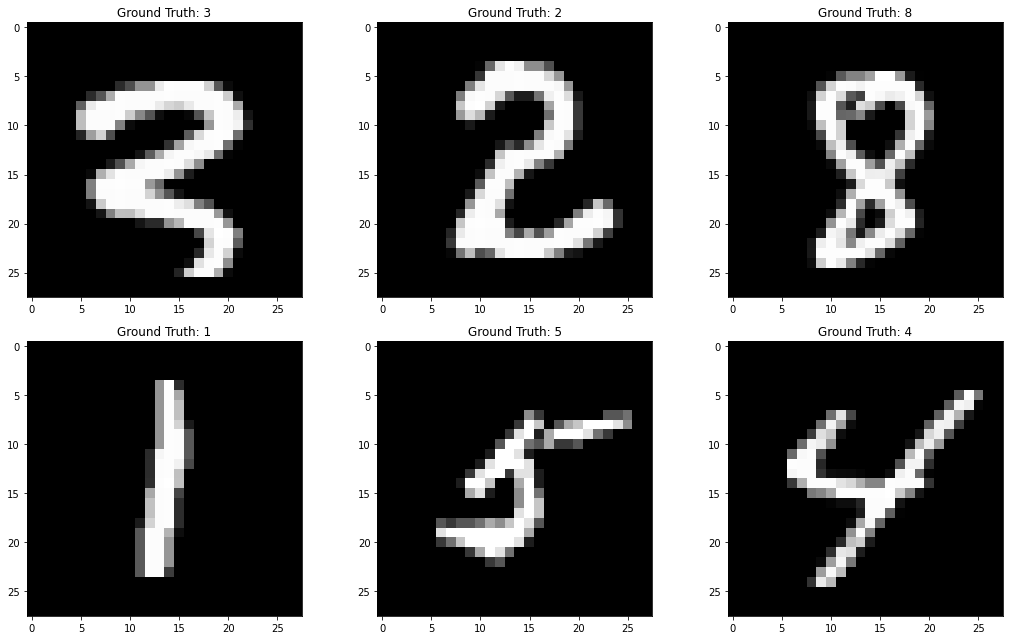

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

### 2. Model Architecture

In [ ]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

### 3. Cost Function Define (Loss Function Define)  

In [ ]:
cls_loss = nn.CrossEntropyLoss()

### 4. Train & Evaluation

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = LinearModel()
print(torch.cuda.is_available())
device =  'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

import time

epoch = 30
for i in range(epoch):
    ts = time.time()
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
 
        input_X = input_X.to(device)
        true_y = true_y.to(device)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        acc = correct.item() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    
    te = time.time()
    td = te - ts
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%, {:3.1f}'.format(i, train_loss, val_loss, acc*100,td))

False
Number of 7850 parameters
Epoch: 0, Train Loss: 0.755496268991924, Val Loss: 0.5037541819524162, Test Acc: 87.97%, 8.3
Epoch: 1, Train Loss: 0.4366338272076434, Val Loss: 0.4294894279181203, Test Acc: 89.56%, 8.5
Epoch: 2, Train Loss: 0.38716141639463125, Val Loss: 0.39745601973956146, Test Acc: 90.14999999999999%, 8.6
Epoch: 3, Train Loss: 0.3627955314067319, Val Loss: 0.38014340362971344, Test Acc: 90.51%, 8.3
Epoch: 4, Train Loss: 0.347190706854891, Val Loss: 0.3684453192768218, Test Acc: 90.78%, 8.3
Epoch: 5, Train Loss: 0.336320338727873, Val Loss: 0.3597030677372896, Test Acc: 91.08000000000001%, 8.3
Epoch: 6, Train Loss: 0.3278192295823866, Val Loss: 0.35350995614558833, Test Acc: 91.14%, 8.4
Epoch: 7, Train Loss: 0.3212290630697289, Val Loss: 0.3483499848767172, Test Acc: 91.18%, 8.3
Epoch: 8, Train Loss: 0.3158987525212186, Val Loss: 0.3446267877198473, Test Acc: 91.32000000000001%, 8.4
Epoch: 9, Train Loss: 0.3113861664786668, Val Loss: 0.3411630120458482, Test Acc: 91.

### 5. Report Experiment  

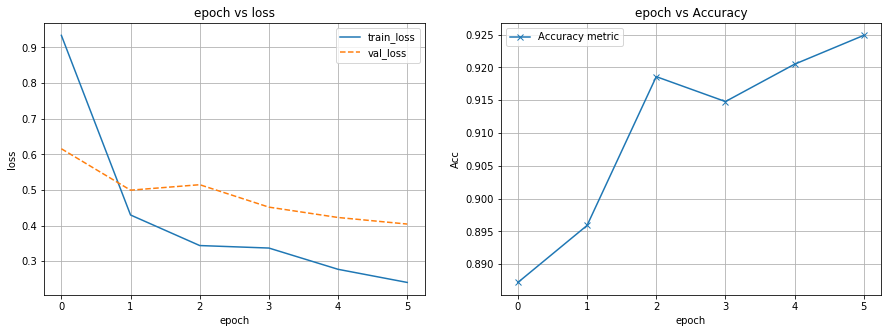

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()